In [1]:
%matplotlib inline
from schrodinger import structure
from schrodinger.structutils import analyze
from schrodinger.structutils import rmsd

In [2]:
import numpy as np
import pickle as pkl
import matplotlib
import matplotlib.pyplot as plt
import site; site.getsitepackages()

['/Users/chengminghe/Dropbox/research/ubq/md/schrodinger.ve/lib/python3.8/site-packages',
 '/opt/schrodinger/suites2023-1/internal/lib/python3.8/site-packages']

In [5]:
sts_ori = []
for i in range(0, 1000):
    print(i)
    path = "/Users/chengminghe/Dropbox/research/ubq/md/ubiquitin/snapshots_prot_no_align/3ons_1000ns_" + str(i) + ".maegz"
    st = structure.Structure.read(path)
    # remove non-protein
    non_protein_atoms = analyze.evaluate_asl(st, '(NOT protein) or (ligand) or (solvent)')
    st.deleteAtoms(non_protein_atoms)
    sts_ori.append(st)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [6]:
sts_ori[-1].atom[20].xyz

[1.675023, 2.754168, 11.596216]

In [7]:
# align structures. Ref: the first snapshot 
sts = sts_ori.copy()
ref_st = sts[0]
asl_for_superimpose = "(heavy_atoms) and (backbone) and (res. 1-70)"
ref_st_atoms_for_superimpose = analyze.evaluate_asl(ref_st, asl_for_superimpose)

for i in range(1, len(sts)):
    trg_st = sts[i]
    trg_st_atoms_for_superimpose = analyze.evaluate_asl(trg_st, asl_for_superimpose)
    # superimpose
    superimpose_rmsd = rmsd.superimpose(ref_st, ref_st_atoms_for_superimpose, trg_st, trg_st_atoms_for_superimpose, move_which=rmsd.MOLECULES)

In [8]:
sts_ori[-1].atom[20].xyz

[2.3757399696365153, -5.98803567765405, 3.2138374227687816]

In [59]:
all_resnum = [res.resnum for res in sts[0].residue]
# get residues that have amide bond    
H_asl = "protein and (atom.ptype H)"
H_resnum = np.array([st.atom[n].resnum for n in analyze.evaluate_asl(sts[0], H_asl)])
N_asl = "protein and (atom.ptype N)"
N_resnum = np.array([st.atom[n].resnum for n in analyze.evaluate_asl(sts[0], N_asl)])
valid_resnum = np.array([n for n in all_resnum if (n in H_resnum and n in N_resnum)])

In [70]:
C_asl = "protein and (atom.ptype C)"
C_resnum = np.array([st.atom[n].resnum for n in analyze.evaluate_asl(sts[0], H_asl)])
N_asl = "protein and (atom.ptype N)"
N_resnum = np.array([st.atom[n].resnum for n in analyze.evaluate_asl(sts[0], N_asl)])
valid_resnum_nc = np.array([n for n in all_resnum if (n in C_resnum and n in N_resnum)])
len(valid_resnum)

72

In [68]:
Ca_asl = "protein and (atom.ptype Ca)"
Ca_resnum = np.array([st.atom[n].resnum for n in analyze.evaluate_asl(sts[0], H_asl)])
N_asl = "protein and (atom.ptype N)"
N_resnum = np.array([st.atom[n].resnum for n in analyze.evaluate_asl(sts[0], N_asl)])
valid_resnum_nca = np.array([n for n in all_resnum if (n in Ca_resnum and n in N_resnum)])
len(Ca_resnum)

72

In [71]:
# extract nc vectors
nc_bond_vec = []
for i in range(0, len(sts)):
    st = sts[i]
  
    C_coor = np.array([st.atom[n].xyz for n in analyze.evaluate_asl(st, C_asl) if st.atom[n].resnum in valid_resnum_nc])
    N_coor = np.array([st.atom[n].xyz for n in analyze.evaluate_asl(st, N_asl) if st.atom[n].resnum in valid_resnum_nc])
    
    unit_vec = (C_coor[:-1]-N_coor[1:])/np.linalg.norm((C_coor[:-1]-N_coor[1:]), axis=-1, keepdims=True)
    nc_bond_vec.append(unit_vec)
nc_bond_vec = np.stack(nc_bond_vec, 0)

In [72]:
# extract nca vectors
nca_bond_vec = []
for i in range(0, len(sts)):
    st = sts[i]
  
    Ca_coor = np.array([st.atom[n].xyz for n in analyze.evaluate_asl(st, Ca_asl) if st.atom[n].resnum in valid_resnum_nca])
    N_coor = np.array([st.atom[n].xyz for n in analyze.evaluate_asl(st, N_asl) if st.atom[n].resnum in valid_resnum_nca])
    
    unit_vec = (Ca_coor-N_coor)/np.linalg.norm((Ca_coor-N_coor), axis=-1, keepdims=True)
    nca_bond_vec.append(unit_vec)
nca_bond_vec = np.stack(nca_bond_vec, 0)

In [73]:
# extract amide bond vectors
amide_bond_vec = []
for i in range(0, len(sts)):
    st = sts[i]
    
    H_coor = np.array([st.atom[n].xyz for n in analyze.evaluate_asl(st, H_asl) if st.atom[n].resnum in valid_resnum])
    N_coor = np.array([st.atom[n].xyz for n in analyze.evaluate_asl(st, N_asl) if st.atom[n].resnum in valid_resnum])
    
    unit_vec = (H_coor-N_coor)/np.linalg.norm((H_coor-N_coor), axis=-1, keepdims=True)
    amide_bond_vec.append(unit_vec)
amide_bond_vec = np.stack(amide_bond_vec, 0)

In [74]:
nc_bond_vec.shape

(1000, 71, 3)

In [12]:
bfac = np.array([res.temperature_factor for res in st.residue if res.resnum in valid_resnum])

In [13]:
average_st = analyze.get_average_structure(sts)

In [14]:
average_rmsds = []
ref_st = average_st
for trg_res_num in valid_resnum:
    average_rmsd = 0.
    for trg_st in sts:
        rmsd_asl = "protein and (atom.ptype H or atom.ptype N) and res. " + str(trg_res_num)
        trg_res = analyze.evaluate_asl(trg_st, rmsd_asl)
        _rmsd = rmsd.calculate_in_place_rmsd(ref_st, trg_res, trg_st, trg_res)
        average_rmsd += _rmsd
    average_rmsd /= len(sts)
    average_rmsds.append(average_rmsd)

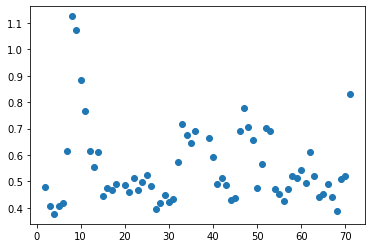

In [15]:
plt.scatter(valid_resnum[:-1], average_rmsds[:-1])
plt.show()

In [16]:
average_rmsds[np.where(valid_resnum==20)[0].item()]

0.48491509659751575

## C_I(100ns)

In [17]:
def c_int_1(t, bond_vec):
    tot_timesteps = bond_vec.shape[0]
    assert t<=tot_timesteps
    result = 0
    for timestep in range(tot_timesteps):
        a = bond_vec[timestep] # (N, 3)
        b = bond_vec[t-1] # (N, 3)
        result += 3*(a*b).sum(-1)**2-1
    result /= tot_timesteps
    result *= 0.5
    return result

In [75]:
# 100ns
block= [10,20,50,100,200,500]
c_int_100 = c_int_1(200, nc_bond_vec)

In [76]:
(c_int_100)

array([0.9305829 , 0.96096605, 0.94880064, 0.88536031, 0.8838366 ,
       0.69736669, 0.83631114, 0.69439707, 0.76880459, 0.76809103,
       0.85983888, 0.85690233, 0.88129705, 0.93900662, 0.92285802,
       0.93735931, 0.85756146, 0.9116386 , 0.94482264, 0.85261156,
       0.80767395, 0.92934603, 0.94755164, 0.80711091, 0.91605771,
       0.93702291, 0.96434459, 0.97080921, 0.90771271, 0.96018454,
       0.87562099, 0.89950297, 0.91280846, 0.90491004, 0.81636695,
       0.85115852, 0.93187648, 0.88260384, 0.92577246, 0.86945856,
       0.92495509, 0.8883732 , 0.95493057, 0.90370017, 0.86003805,
       0.80678313, 0.71692534, 0.90528153, 0.91356914, 0.93780309,
       0.92846318, 0.69233553, 0.90987566, 0.93091688, 0.95678018,
       0.95857513, 0.95980974, 0.82400984, 0.91420387, 0.92924181,
       0.80657667, 0.95648019, 0.93164931, 0.91346537, 0.90163307,
       0.88253918, 0.88675192, 0.72249594, 0.94181658, 0.82530394,
       0.72511928])

In [79]:
block= [10,20,50,100,200,500]
s2_list = [c_int_1(b, nca_bond_vec) for b in block]

data = {
    '3ons_1000ns_nca_cint':(block,s2_list)
}
with open("3ons_1000ns_nca_cint", "wb") as f:
    pkl.dump(data, f)

In [58]:
valid_resnum[:-1]

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71])

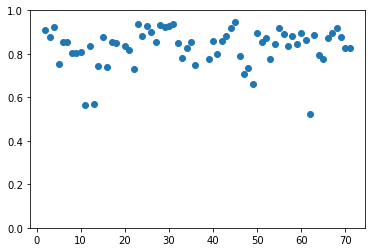

In [51]:
plt.scatter(valid_resnum[:-1], c_int_100[:-1])
plt.ylim(0,1)
plt.show()

In [45]:
with open("3ons_1000ns", "wb") as f:
    pickle.dump(cov_ensemble_nc, f)

IsADirectoryError: [Errno 21] Is a directory: '3ons_1000ns'

In [21]:
from sklearn.metrics import r2_score

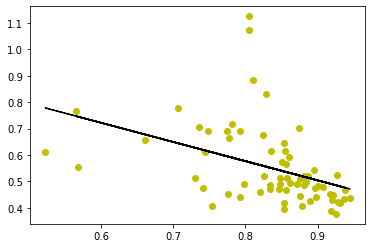

0.17971290322196865

In [22]:
x = c_int_100[:-1]
y = average_rmsds[:-1]
coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef) 
# poly1d_fn is now a function which takes in x and returns an estimate for y

plt.plot(x, y, 'yo', x, poly1d_fn(x), '--k') #'--k'=black dashed line, 'yo' = yellow circle marker
plt.show()
r2_score(y,  poly1d_fn(x))

## P2

In [20]:
def c_int_2(bond_vec):
    tot_timesteps = bond_vec.shape[0]
    xx = 0
    yy = 0
    zz = 0
    xy = 0
    xz = 0
    yz = 0
    for timestep in range(tot_timesteps):
        a = bond_vec[timestep] # (N, 3)        
        xx += a[:, 0]*a[:, 0]
        yy += a[:, 1]*a[:, 1]
        zz += a[:, 2]*a[:, 2]
        xy += a[:, 0]*a[:, 1]
        xz += a[:, 0]*a[:, 2]
        yz += a[:, 1]*a[:, 2]
    
    xx = (xx/tot_timesteps)**2
    yy = (yy/tot_timesteps)**2
    zz = (zz/tot_timesteps)**2
    xy = (xy/tot_timesteps)**2
    xz = (xz/tot_timesteps)**2
    yz = (yz/tot_timesteps)**2
    
    return 1.5*(xx + yy + zz + 2*xy + 2*xz + 2*yz)-0.5

In [21]:
c_int_inf_p2 = c_int_2(amide_bond_vec)

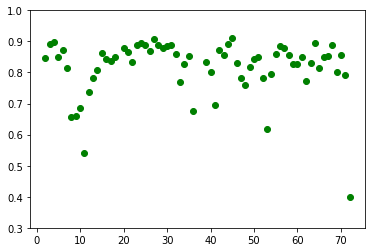

In [22]:
plt.scatter(valid_resnum, c_int_inf_p2, color='g')
# plt.scatter(valid_resnum[:-1], c_int_100[:-1], color='r')
plt.ylim([0.3, 1])
plt.show()

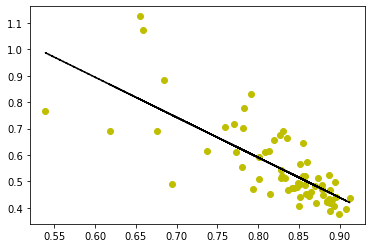

0.5658671928811669

In [23]:
x = c_int_inf_p2[:-1]
y = average_rmsds[:-1]
coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef) 
# poly1d_fn is now a function which takes in x and returns an estimate for y

plt.plot(x, y, 'yo', x, poly1d_fn(x), '--k') #'--k'=black dashed line, 'yo' = yellow circle marker
plt.show()
r2_score(y,  poly1d_fn(x))

## fit

In [24]:
from scipy.optimize import curve_fit

In [25]:
# extract amide bond vectors
amide_bond_vec_ori = []
for i in range(0, len(sts_ori)):
    st = sts_ori[i]
    H_coor = np.array([st.atom[n].xyz for n in analyze.evaluate_asl(st, H_asl) if st.atom[n].resnum in valid_resnum])
    N_coor = np.array([st.atom[n].xyz for n in analyze.evaluate_asl(st, N_asl) if st.atom[n].resnum in valid_resnum])
    amide_bond_vec_ori.append(H_coor-N_coor)
amide_bond_vec_ori = np.stack(amide_bond_vec_ori, 0)

In [26]:
amide_bond_vec_ori.shape

(1000, 68, 3)

In [27]:
def c_int_3(t, bond_vec):
    tot_timesteps = bond_vec.shape[0]
    assert t<=tot_timesteps
    
    bond_length = np.linalg.norm(bond_vec, axis=-1, keepdims=True) # (t, N, 1)
    bond_vec_normalized = bond_vec/np.linalg.norm(bond_vec, axis=-1, keepdims=True)
    xx = bond_vec_normalized[:, :, 0]**2 # (t, N)
    yy = bond_vec_normalized[:, :, 1]**2
    zz = bond_vec_normalized[:, :, 2]**2
    xy = bond_vec_normalized[:, :, 0] * bond_vec_normalized[:, :, 1]
    yx = xy # symmetric
    xz = bond_vec_normalized[:, :, 0] * bond_vec_normalized[:, :, 2]
    zx = xz
    yz = bond_vec_normalized[:, :, 1] * bond_vec_normalized[:, :, 2]
    zy = yz
    x_col = np.stack([xx, yx, zx], -1)
    y_col = np.stack([xy, yy, zy], -1)
    z_col = np.stack([xz, yz, zz], -1)
    phi = np.stack([x_col, y_col, z_col], -1)/bond_length[..., None]**3 # (t, N, 3, 3)
    
    phi_0_phi_t_accu = 0 # accumulator for calculating the average
    tr_phi_0_tr_phi_t_accu = 0
    r_accu = 0
    for timestep in range(t):
        phi_0_phi_t = phi[0, ...]@phi[timestep, ...] # (N, 3, 3)
        tr_phi_0_tr_phi_t = np.trace(phi[0, ...], axis1=-2, axis2=-1)*np.trace(phi[timestep, ...], axis1=-2, axis2=-1)
        phi_0_phi_t_accu += phi_0_phi_t
        tr_phi_0_tr_phi_t_accu += tr_phi_0_tr_phi_t
        r_accu += (bond_length[timestep, :, 0])**(-6)
    phi_0_phi_t_accu /= t
    tr_phi_0_tr_phi_t_accu /= t
    r_accu /= t
    result = (1/r_accu) * 0.5*(3*np.trace(phi_0_phi_t_accu, axis1=-2, axis2=-1) - tr_phi_0_tr_phi_t_accu)
    return result

In [28]:
def c_int_4(t, bond_vec):
    tot_timesteps = bond_vec.shape[0]
    assert t<=tot_timesteps
    
    bond_length = np.linalg.norm(bond_vec, axis=-1) # (t, N, 1)
    bond_vec_normalized = bond_vec/np.linalg.norm(bond_vec, axis=-1, keepdims=True) # (t, N, 3)
    
    # prepare cos(theta) map
    cos_map = (bond_vec_normalized[t:t+1, :, :]*bond_vec_normalized[:tot_timesteps-t]).sum(-1) # (tot-t+1, N, 3). cos(theta(t, i))
    
    # prepare denominator map
    r_map = (bond_length[t:t+1, ...]**3) * (bond_length[t:, ...]**3)
    
    result = ((3*cos_map**2 - 1)/r_map).mean(0)/2
    return result

In [29]:
c_t = []
timestep = []
for t in range(1, amide_bond_vec_ori.shape[0]):
    c_t.append(c_int_3(t, amide_bond_vec_ori))
    timestep.append(t)
c_t = np.stack(c_t, 0)
timestep = np.stack(timestep, 0)
# c_t[0], c_t.shape, timestep.shape

In [79]:
c_t.shape

(999, 68)

In [80]:
# # determine tau_M
# def motional_average_ls_cf(t, tau_M, S2):
#     return np.exp(-t/tau_M)*S2

In [81]:
# params = []
# # fit to first 10ns
# for i in range(10):
#     popt, pcov = curve_fit(motional_average_ls_cf, timestep, c_t[:, i], maxfev=100000, bounds=((0, 0), (np.inf, 1)))
#     params.append(popt)
# params = np.stack(params, 0)

In [82]:
# params

In [83]:
# resnum = 1
# plt.plot(timestep[:10], motional_average_ls_cf(timestep[:10], *params[resnum]), 'g--')
# plt.scatter(timestep[:10], c_t[:10, resnum])

In [38]:
def extended_ls_cf(t, tau_M, S2, S_f2, tau_e):
    return np.exp(-t/tau_M)*(S2 + (S_f2-S2)*np.exp(-t/tau_e))
def original_ls_cf(t, tau_M, S2, tau_e):
    return (np.exp(-t/tau_M))*(S2 + (1-S2)*np.exp(-t/tau_e))

In [39]:
# # extended LS
# s2 = []
# for i in range(c_t.shape[-1]):
#     popt, pcov = curve_fit(extended_ls_cf, timestep, c_t[:, i], maxfev=100000, bounds=((0, 0, 0, 0), (np.inf, 1, 1, np.inf)))
#     s2.append(popt)
# s2 = np.stack(s2, 0)

# original LS
s2 = []
for i in range(c_t.shape[-1]):
    popt, pcov = curve_fit(original_ls_cf, timestep, c_t[:, i], maxfev=100000, bounds=((0, 0, 0), (np.inf, 1, np.inf)))
    s2.append(popt)
s2 = np.stack(s2, 0)

In [40]:
s2[1]

array([5.27128744e+04, 9.03348583e-01, 5.80083403e+00])

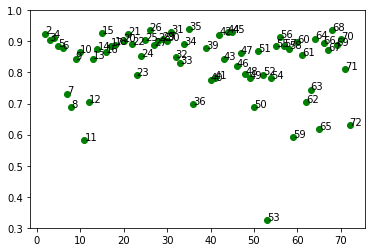

In [101]:
plt.scatter(valid_resnum, s2[:, 1], color='g')
for i, txt in enumerate(valid_resnum):
    plt.annotate(txt, (valid_resnum[i], s2[:, 1][i]))
plt.ylim([0.3, 1])
plt.show()

In [49]:
np.stack([valid_resnum, s2[:, 1]], 1)

array([[ 2.        ,  0.92511256],
       [ 3.        ,  0.90334858],
       [ 4.        ,  0.9122175 ],
       [ 5.        ,  0.88576159],
       [ 6.        ,  0.87971765],
       [ 7.        ,  0.73188176],
       [ 8.        ,  0.68730749],
       [ 9.        ,  0.84317506],
       [10.        ,  0.86534408],
       [11.        ,  0.58352336],
       [12.        ,  0.70441423],
       [13.        ,  0.84477613],
       [14.        ,  0.87445787],
       [15.        ,  0.9257234 ],
       [16.        ,  0.86656665],
       [17.        ,  0.88661071],
       [18.        ,  0.8900211 ],
       [20.        ,  0.89993845],
       [21.        ,  0.92291464],
       [22.        ,  0.89070462],
       [23.        ,  0.79222834],
       [24.        ,  0.85174329],
       [25.        ,  0.90511531],
       [26.        ,  0.93600391],
       [27.        ,  0.88874301],
       [28.        ,  0.90290518],
       [29.        ,  0.90693784],
       [30.        ,  0.9025927 ],
       [31.        ,

In [43]:
timestep.shape, 

((999,),)

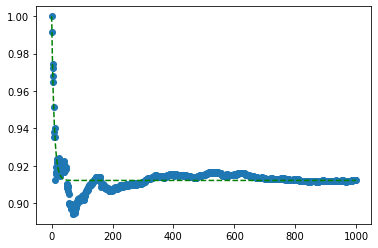

In [44]:
end_time = 1000
time_range = np.arange(0, end_time, 0.01)
resnum = 2
plt.plot(time_range, original_ls_cf(time_range, *s2[resnum]), 'g--')
plt.scatter(timestep[:end_time], c_t[:end_time, resnum])

## Compare with DE Shaw result

In [50]:
import pandas as pd

In [88]:
deshaw_data = pd.read_csv("../data/deshaw_data.txt", delim_whitespace=True, header=None)

In [94]:
s2_data = np.stack([valid_resnum, s2[:, 1]], 1)
common_res = [i for i in valid_resnum if i in deshaw_data[0].values]
s2_common_res = s2_data[s2_data[:, 0]==common_res][:, 1]
deshaw_s2_common_res = deshaw_data.loc[deshaw_data[0].isin(common_res)][1].values

In [95]:
s2_common_res.shape, deshaw_s2_common_res.shape

((68,), (68,))

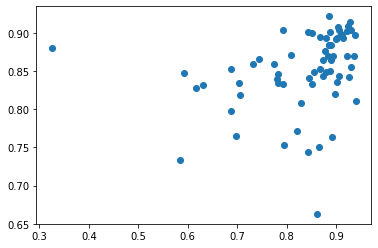

In [96]:
plt.scatter(s2_common_res, deshaw_s2_common_res)